# Modeling Loan Default Prediction

This notebook is the final part of our project series, focusing on building and optimizing models to predict loan defaults. Leveraging insights from our prior data analysis, we will develop a series of machine learning models, evaluate their performance, and fine-tune them to achieve optimal results. This structured modeling approach aims to produce a robust, reliable model for predicting loan defaults, with **ROC AUC** as our main evaluation metric.

The ROC AUC metric has been selected because it provides a balanced measure of performance for binary classification, especially when handling imbalanced data, as it focuses on distinguishing between default and non-default cases across various thresholds.


## Notebook Roadmap

1. **Baseline Model:**
    * We will start with a baseline model using only the original features from the applications.csv table, which will serve as a performance benchmark.
    * A preprocessing pipeline will handle missing values, scaling, and encoding, ensuring consistency in feature preparation.
    * For the baseline model, Logistic Regression will be used, establishing initial ROC AUC performance metrics.
2. **Feature Engineering:**
    * Based on insights from previous notebooks, we will introduce additional, meaningful features from various data sources:
        * Derived features from columns in applications.csv.
        * Aggregated features from prior loan applications within the Home Credit Group.
        * Aggregated features from clients' previous applications with external financial institutions.
    * These engineered features will deepen our dataset’s insights into client financial behavior, potentially enhancing predictive performance.
3. **Modeling and Comparison:**
    * We will train and evaluate a variety of algorithms, comparing their performance based on the ROC AUC metric:
        * Random Forest
        * Decision Tree
        * Logistic Regression 
        * Light Gradient Boosting Machine
        * Categorical Boosting,
    * For each model, we will employ techniques to handle the class imbalance present in our dataset, which can impact the accuracy of predictions across classes.
4. **Hyperparameter Tuning:**
    * We will fine-tune hyperparameters for the most promising models to maximize ROC AUC and overall model performance.
5. **Feature Importance Analysis:**
    * Using SHAP (SHapley Additive exPlanations), we will analyze feature importance in our best-performing models, allowing us to identify which features most influence loan default predictions.
    
## Conclusions from the Modelling Process:
1. **Baseline Model:**
* The Logistic Regression model was trained using the original features from the applications.csv table. It achieved an ROC AUC of approximately 0.75 on the validation data. The class_weight parameter was used to address the class imbalance.
2. **Imbalance Handling:**
* Three techniques were explored to tackle the class imbalance: adjusting the model's hyperparameters (which control class weights), undersampling the majority class, and using SMOTE. The performance was quite similar across simpler models (Random Forest, Logistic Regression, Decision Tree). Interestingly, in some cases, undersampling resulted in slightly higher scores despite using less data. For gradient boosting models, adjusting the balancing parameters yielded better results.
3. **Model Performance:**
* Among the simpler models (Random Forest, Logistic Regression, and Decision Tree), Logistic Regression emerged as the best performer. It also demonstrated the advantage of producing high scores when trained on undersampled data.
* We also tested gradient boosting models, and LightGBM was selected as the top performer due to its high ROC AUC and efficient training time.
4. **Final Model Selection:**
* The final models chosen are **LightGBM** and **Logistic Regression**. LightGBM achieved an ROC AUC of 0.786, while Logistic Regression scored 0.766. Despite the slightly lower score, Logistic Regression was chosen for its simplicity and its effective performance on the undersampled dataset.
5. **Feature Importance:**
* Both models identified important features, though there were some differences in the rankings. However, several features appeared in both models' top lists, including:
    * External score features: These proved to have a strong influence on the likelihood of default. A higher external score significantly reduces the chances of default.
    * CreditTerm: This feature was highly important, with longer credit terms associated with a lower probability of default.
    * Features from previous_applications.csv: These also showed high importance, underscoring the value of historical data from the Home Credit Group.
    * Debt-related features: A history of debt significantly increases the likelihood of default.
    * Late payments: Past late payments also contributed to higher default rates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   FunctionTransformer,
                                  RobustScaler)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import catboost
from catboost import CatBoostClassifier, Pool
import shap
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import optuna
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pipeline
from sklearn.base import clone
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.preprocessing import helper_functions
from utils.preprocessing import (baseline_preprocessing_pipeline,
                           updated_preprocessing_pipeline,
                          encode_features_for_correlation,
                          apply_random_undersampling,
                          apply_over_under_sampling,
                          prepare_categorical_datasets)
from utils.feature_engineering import (create_application_feature, 
                                 merge_application_features,
                                 drop_correlated_features)
import joblib

In [2]:
application = pd.read_csv("application_after_eda.csv", index_col=0)
test_data = pd.read_csv("application_test_after_eda.csv", index_col=0)
application_new_features = pd.read_csv("previous_applications_agg_features.csv",
                                       index_col=0)
application_bureau_features = pd.read_csv("bureau_agg_features.csv",
                                          index_col=0)

## Baseline model

**Preprocessing preparation**

In [3]:
ext_source_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

surround_cols = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                 "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
bureau_enq_cols = [col for col in application if col.startswith("AMT_R")]
indicator_cols = [col for col in application.columns
                  if col.startswith("FLAG_") or col.startswith("REG_")
                 or col.startswith("LIVE_")]
passthrough_cols = list()
passthrough_cols.extend(indicator_cols)
passthrough_cols.append("REGION_RATING_CLIENT_W_CITY")
passthrough_cols.append("REGION_POPULATION_RELATIVE")
passthrough_cols.append("DOCUMENT_SUM")

log_rob_cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT",
                "AMT_GOODS_PRICE", "AMT_ANNUITY",
                "DAYS_EMPLOYED", "DAYS_REGISTRATION",
               "CNT_CHILDREN", "CNT_FAM_MEMBERS"] + surround_cols + bureau_enq_cols

std_cols = (["DAYS_BIRTH", "HOUR_APPR_PROCESS_START",
             "DAYS_ID_PUBLISH", "DAYS_LAST_PHONE_CHANGE",
            "INDICATOR_SUM", "CHI2_SUM"])

one_hot_cols = ["ORGANIZATION_TYPE", "OCCUPATION_TYPE",
                "NAME_INCOME_TYPE", "NAME_TYPE_SUITE",
                "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]

preprocessing = baseline_preprocessing_pipeline(log_rob_cols,
                                               std_cols,
                                               one_hot_cols,
                                               ext_source_cols,
                                               passthrough_cols)

In [4]:
X = application.drop(columns="TARGET")
y = application.loc[:, 'TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y)

In [5]:
log_reg = LogisticRegression(class_weight="balanced",
                             random_state=0, max_iter=1000)
pipe = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", log_reg)
])
helper_functions.get_scores(pipe, X_train, y_train)

{'accuracy': 0.6886859948942259,
 'recall': 0.6725917719925475,
 'precision': 0.1600848544410753,
 'f1': 0.25861601610904583,
 'roc_auc': 0.7477003938049714}

In [6]:
helper_functions.get_scores(pipe, X_val, y_val, fit=False)

{'accuracy': 0.6902439024390243,
 'recall': 0.6727089627391742,
 'precision': 0.16084758006260536,
 'f1': 0.25961912164788187,
 'roc_auc': 0.7483260260578806}

Logistic Regression algorithm with default parameters using only original features have given us almost 0.75 ROC AUC. The accuracy is almost 0.7.

## Feature engineering.
We will add the following features:
   * Features, created from application table:
        * DEBT_TO_INCOME: AMT_CREDIT / AMT_INCOME_TOTAL
        * CREDIT_TERM:  AMT_CREDIT / AMT_ANNUITY
        * TOTAL_FINANCING = AMT_CREDIT + AMT_ANNUITY
        * INCOME_PER_ANNUITY_UNIT = AMT_INCOME_TOTAL / AMT_ANNUITY
        * YEARS_EMPLOYED_PERCENT: the percentage of the years employed relative to the client's age
        * Indicator that the person lives in a populated area
        * Feature, which marks whether a client had a friend who defaulted
        * Feature, which marks whether a client had a friend who had problems with paying or defaulted.
        * Indicator that the person has missing data in bureau columns.
        * Indicator that there were enquiries about the person
        * Create average of external sources.
        * Create sum of external sources
   * Add features from the previous application table
   * Add features from the bureau table

In [7]:
X = create_application_feature(X, ext_source_cols)
test_data = create_application_feature(test_data, ext_source_cols)

We will also drop bureau enquiries and surroundings related columns. They are highly skewed. Instead, newly created features from these columns will be used

In [8]:
X.drop(columns=bureau_enq_cols+surround_cols, inplace=True)
test_data.drop(columns=bureau_enq_cols+surround_cols, inplace=True)

In [9]:
X = merge_application_features(X, application_new_features, 
                               application_bureau_features)

test_data = merge_application_features(test_data, application_new_features, 
                                       application_bureau_features)

**Dropping strongly correlated features**:
* We will convert all features into numeric type and analyze their correlations

In [10]:
one_hot_encode_cols = ["NAME_CONTRACT_TYPE", "NAME_TYPE_SUITE", 
                   "NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", 
                  "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", 
                   "ORGANIZATION_TYPE"]
pd.set_option('future.no_silent_downcasting', True)
X_analysis = encode_features_for_correlation(X, one_hot_encode_cols)

In [11]:
corr_check = X_analysis.corr("spearman")
strong_corr = corr_check[(corr_check > 0.95) | (corr_check < -0.95)].stack()

strong_corr = strong_corr[strong_corr.index.get_level_values(0)
                      != strong_corr.index.get_level_values(1)]
strong_corr

AMT_CREDIT                          AMT_GOODS_PRICE                       0.983943
AMT_GOODS_PRICE                     AMT_CREDIT                            0.983943
DAYS_EMPLOYED                       DAYS_EMPLOYED_PERCENT                 0.953037
FLAG_EMP_PHONE                      NAME_INCOME_TYPE_Other               -0.999527
                                    OCCUPATION_TYPE_Unemployed           -0.999868
                                    ORGANIZATION_TYPE_Unemployed         -0.999868
REGION_RATING_CLIENT                REGION_RATING_CLIENT_W_CITY           0.950046
REGION_RATING_CLIENT_W_CITY         REGION_RATING_CLIENT                  0.950046
INDICATOR_SUM                       CHI2_SUM                              0.981797
CHI2_SUM                            INDICATOR_SUM                         0.981797
DAYS_EMPLOYED_PERCENT               DAYS_EMPLOYED                         0.953037
HAD_DPD_BUREAU                      DPD_SUM_BUREAU                        0.999924
    

Drop:
* AMT_GOODS_PRICE
* REGION_RATING_CLIENT
* DAYS_EMPLOYED_PERCENT
* CHI2_SUM
* FLAG_EMP_PHONE
* HAD_AMT_OVERDUE_BUREAU
* DPD_SUM_BUREAU
* SUM_AMT_OVERDUE_BUREAU

Replace "Unemployed" values in Organization type and Occupation type columns with np.nan

In [12]:
columns_to_drop = [
    "AMT_GOODS_PRICE", "CHI2_SUM", "DAYS_EMPLOYED_PERCENT",
    "REGION_RATING_CLIENT", "FLAG_EMP_PHONE", "HAD_AMT_OVERDUE_BUREAU",
    "DPD_SUM_BUREAU", "SUM_AMT_OVERDUE_BUREAU"
]

categorical_columns = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
drop_correlated_features(X, test_data, columns_to_drop, categorical_columns)

passthrough_cols.remove("FLAG_EMP_PHONE")
indicator_cols.remove("FLAG_EMP_PHONE")

## Modelling

**Modify our preprocessing pipeline**

In [13]:
# extract categorical columns for label encoding
cat_cols = X.select_dtypes("object").columns
bureau_cat_cols = X[cat_cols].columns[X[cat_cols].columns.str.endswith("BUREAU")]
prev_cat_cols = X[cat_cols].columns[X[cat_cols].columns.str.endswith("PREV")]

# add some columns to passthrough list
for column in ["LIVES_IN_POPULATED_AREA", "FRIEND_DEFAULTED",
               "FRIEND_HAD_DPD", "MISSING_BUREAU", "HAD_ENQUIRIES"]:
    passthrough_cols.append(column)
    
# add columns, related to external sources
ext_source_cols.append("AVG_EXT_SOURCE")
ext_source_cols.append("SUM_EXT_SOURCE")

In [14]:
# some of the newly created features will go through numeric transformations:
log_rob_cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY",
                "DAYS_EMPLOYED", "DAYS_REGISTRATION",
               "DEBT_TO_INCOME", "INCOME_PER_ANNUITY_UNIT",
               "AVERAGE_AMT_CREDIT_PREV", "APPLICATION_COUNT_PREV",
                "AVERAGE_INSTALLMENT_PREV", "AVERAGE_RATE_DOWN_PAYMENT_PREV",
               "INSTALLMENT_COUNT_MEAN_PREV", "LAST_SNAPSHOT_MAX_PREV",
               "APPLICATION_COUNT_BUREAU", "AVG_AMT_CREDIT_SUM_BUREAU",
               "AVG_LOAN_LENGTH_BUREAU", "LAST_SNAPSHOT_MEAN_BUREAU",
               "MAX_AMT_CREDIT_MAX_OVERDUE_BUREAU", "MAX_AMT_CREDIT_SUM_BUREAU",
               "MAX_DAYS_ENDDATE_FACT_BUREAU", "SUM_AMT_DEBT_BUREAU",
               "AVERAGE_DRAWINGS_PREV", "DPD_COUNT"]

log_cols = ["AVERAGE_CNT_PAYMENT_PREV", "AVERAGE_LOAN_LENGTH_PREV",
           "DAYS_DECISION_MAX_PREV", "DAYS_DECISION_MEAN_PREV",
           "LAST_SNAPSHOT_MEAN_PREV", "AVG_DAYS_ENDDATE_FACT_BUREAU",
           "MAX_DAYS_CREDIT_BUREAU", "AVG_MONTHS_BALANCE", "LAST_SNAPSHOT_MAX_BUREAU"]


std_cols = (["DAYS_BIRTH", "CNT_CHILDREN", "CNT_FAM_MEMBERS",
             "HOUR_APPR_PROCESS_START", "DAYS_ID_PUBLISH",
            "DAYS_LAST_PHONE_CHANGE", "CREDIT_TERM", "INDICATOR_SUM",
            "AVERAGE_YIELD_GROUP_PREV", "AVG_DAYS_CREDIT_BUREAU"])

ordinal_encoding_cols = (["CODE_GENDER", "NAME_CONTRACT_TYPE"] + list(bureau_cat_cols)
                         + list(prev_cat_cols))

# establish the final preprocessing pipeline
preprocessing = updated_preprocessing_pipeline(log_rob_cols,
                                              std_cols,
                                              log_cols,
                                              one_hot_cols,
                                              ordinal_encoding_cols,
                                              ext_source_cols,
                                              passthrough_cols)

Train-validation split:

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y)

To tackle imblancing problem, we will consider the following techniques:
* Oversampling using SMOTE
* Random undersampling
* Using original dataset with balancing hyperparameter

In [16]:
# reduce memory usage of the dataframes
helper_functions.reduce_memory_usage(X_train)
helper_functions.reduce_memory_usage(X_val);

# preprocess the tables
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_val_preprocessed = preprocessing.transform(X_val)

# create undersampled dataset 
X_train_under, y_train_under = apply_random_undersampling(X_train_preprocessed, 
                                                          y_train, 
                                                          sampling_strategy=1)

# use smote to balance the classes more
X_train_over_under, y_train_over_under = apply_over_under_sampling(X_train_preprocessed,
                                                                   y_train, 
                                                                   smote_strategy=0.2, 
                                                                   under_strategy=0.5)

Starting memory usage of dataframe: 217.71 MB
Final memory usage of dataframe: 68.27 MB
Reduced by: 68.6%
Starting memory usage of dataframe: 54.43 MB
Final memory usage of dataframe: 17.07 MB
Reduced by: 68.6%


Train the following models:
* Logistic Regression
* Decision Tree
* Random Forest

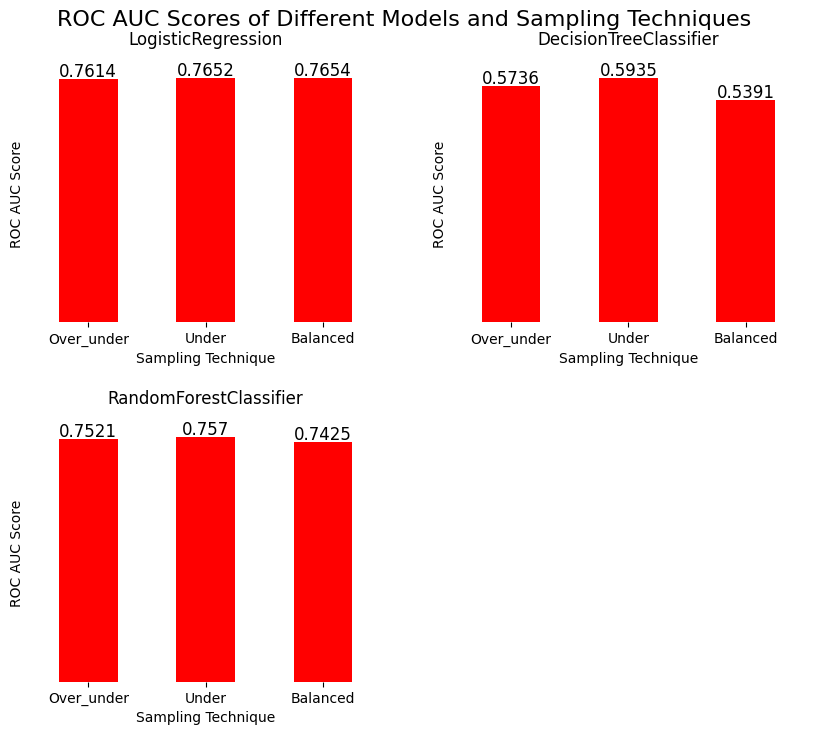

In [17]:
datasets = {"Over_under": (X_train_over_under, y_train_over_under),
           "Under": (X_train_under, y_train_under),
           "Balanced": (X_train_preprocessed, y_train)}

algorithms = [LogisticRegression(C=1, random_state=0, max_iter=800),
             DecisionTreeClassifier(random_state=0),
             RandomForestClassifier(random_state=0)]
helper_functions.plot_model_roc_auc(models=algorithms,
                                   datasets=datasets,
                                   X_val=X_val_preprocessed,
                                   y_val=y_val);

Out of the three models tested, Logistic Regression stands out as the top performer. Interestingly, the models' scores across different datasets are quite similar. In fact, the scores on the undersampled dataset are slightly higher. This suggests that even after reducing the dataset's size significantly, the model maintains its performance, likely because undersampling helps balance the classes and reduces noise, allowing the model to generalize effectively.

**Plot confusion matrices for each of the model, trained on undersampled dataset**

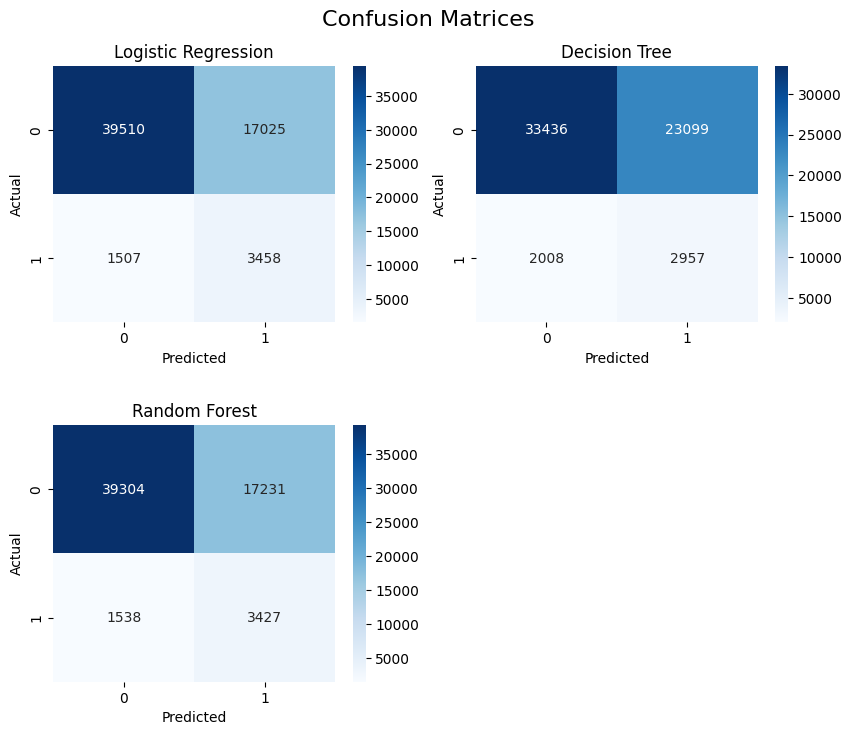

In [18]:
models = [{"model": LogisticRegression(C=1, random_state=0, max_iter=700),
          "name": "Logistic Regression",
          "X_val": X_val_preprocessed,
          "y_val": y_val,
          "X_train": X_train_under,
          "y_train": y_train_under},
         {"model": DecisionTreeClassifier(random_state=0),
          "name": "Decision Tree",
          "X_val": X_val_preprocessed,
          "y_val": y_val,
          "X_train": X_train_under,
          "y_train": y_train_under},
         {"model": RandomForestClassifier(random_state=0),
          "name": "Random Forest",
          "X_val": X_val_preprocessed,
          "y_val": y_val,
          "X_train": X_train_under,
          "y_train": y_train_under}]

helper_functions.plot_confusion_matrices(models);

Here we see that logistic regression is best at both identifying more positive and negative classes.

**Gradient Boosting Algorithms**
* CatBoost
* LightGBM

None of these algorithms require preprocessing of categorical columns and scaling. Therefore, we will train them on original data. We will try the following balancing techniques:
* Undersampling
* Using parameters which are responsible for balancing classes

In [19]:
X_train_cat = prepare_categorical_datasets(X_train)
X_val_cat = prepare_categorical_datasets(X_val)
cat_columns = list(X_train_cat.select_dtypes("category").columns)

X_train_under_cat, y_train_under_cat = apply_random_undersampling(X_train_cat,
                                                                 y_train)
helper_functions.reduce_memory_usage(X_train_under_cat);

Starting memory usage of dataframe: 119.88 MB
Final memory usage of dataframe: 67.34 MB
Reduced by: 43.8%
Starting memory usage of dataframe: 29.97 MB
Final memory usage of dataframe: 16.84 MB
Reduced by: 43.8%
Starting memory usage of dataframe: 10.88 MB
Final memory usage of dataframe: 10.88 MB
Reduced by: 0.0%


In [20]:
datasets = {"Under": (X_train_under_cat, y_train_under_cat),
           "Balanced": (X_train_cat, y_train)}

# specify parameters for LightGBM
num_positive = sum(y_train)
num_negative = len(y_train) - num_positive
scale_pos_weight = num_negative / num_positive
lgb_params = {
    "seed": 0,
    "metric": "auc",
    "objective": "binary",
    "verbose": -1
}

**ROC AUC scores for models with different balancing techniques**

In [21]:
roc_res = helper_functions.train_gradient_boosting_models(datasets,
                                                          X_val_cat,
                                                          y_val,
                                                          cat_columns,
                                                          lgb_params,
                                                          scale_pos_weight)
roc_res = roc_res.unstack().reset_index().rename(columns={
    "level_0": "Balancing Technique",
    "level_1": "Model",
    0: "Score"})

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's auc: 0.890312	val's auc: 0.777907
Dataset: Under. CatBoost best iteration: 725
Dataset: Under. LightGBM best iteration: 184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	train's auc: 0.860325	val's auc: 0.78028
Dataset: Balanced. CatBoost best iteration: 552
Dataset: Balanced. LightGBM best iteration: 217


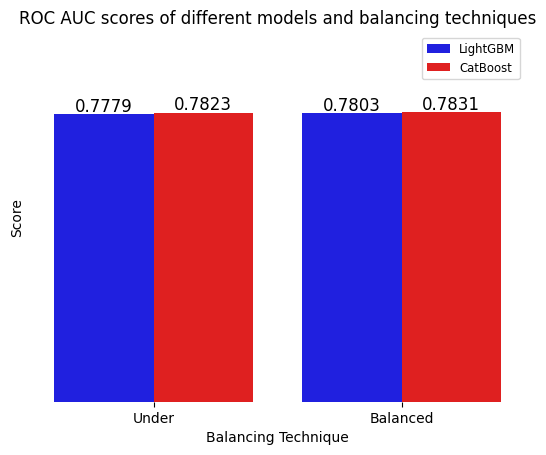

In [24]:
sns.barplot(data=roc_res, x="Balancing Technique", y="Score",
            hue="Model", palette=["blue", "red"])
plt.title("ROC AUC scores of different models and balancing techniques")
helper_functions.customize_bar(axes=plt.gca(), position="v", round_to=4)
plt.ylim(0, 1)
plt.legend(fontsize="small", title_fontsize="small", loc="best");

The above plot indicate to us that using the full datasset produces higher ROC AUC. In LightGBM case, the difference is 0.5%. Also, CatBoost validation scores are higher than LightGBM validation scores. However, to compare the model's performance better, let's use cross-validation

In [25]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
models = [
    ("CatBoost", CatBoostClassifier(iterations=552, 
                                     cat_features=cat_columns, 
                                     auto_class_weights="Balanced",
                                   verbose=0)),
    ("LightGBM", lgb.LGBMClassifier(n_estimators=217, 
                                     scale_pos_weight=scale_pos_weight,
                                   verbose=-1))
]
scores = helper_functions.calculate_cross_val_scores(models, X_train_cat, y_train, cv=skf)

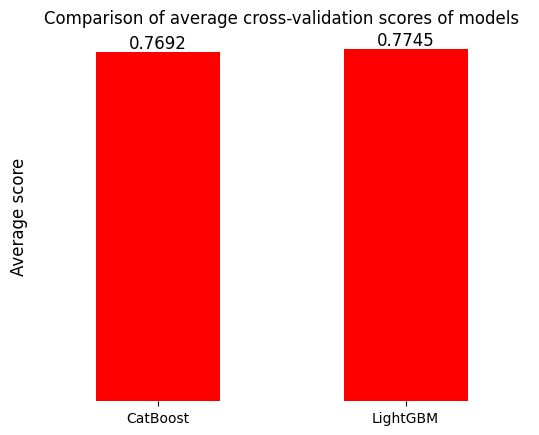

In [26]:
scores.mean().plot(kind="bar", color="red")
ax = plt.gca()
helper_functions.customize_bar(axes=ax, position="v", round_to=4)
ax.set_ylabel("Average score", fontsize=12)
plt.title("Comparison of average cross-validation scores of models");

Here, we see that cross-validation scores are higher for LightGBM model. In addition to that, this model takes significantly less time to train. That is why this model is our clear winner here.

## Hyperparameter tuning

Now, we will try to get the best out of LightGBM model by tuning its hyperparameters. We will use Optuna for this task. In the objective function, cross-validation will be used. Tuning the parameters using cross-validation on the full dataset is computationally expensive. Therefore, we were able to do this on the sample of the data. We have sampled 20% of the data. 

In [27]:
X_cat = prepare_categorical_datasets(X)
X_train_cat_tune, _, y_tune, _ = train_test_split(X_cat,
                                                  y,
                                                  test_size=0.7,
                                                  stratify=y,
                                                  random_state=0)

Starting memory usage of dataframe: 267.45 MB
Final memory usage of dataframe: 81.82 MB
Reduced by: 69.4%


In [28]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

**Specifying the objective function:**

We applied significant regularization to address overfitting, as the model was severely overfitting while still yielding the same validation score. To mitigate this, we reduced the max_depth parameter to a value not higher than 3. Additionally, we limited the num_leaves parameter to a maximum of 60. These adjustments helped us achieve a high validation score while preventing overfitting.

In [29]:
def lgbm_objective(trial):
    lgbm_params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 60),
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 300, 1000),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 50, 300),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        'reg_alpha': trial.suggest_float('reg_alpha', 50, 300),
        'scale_pos_weight': 11.387,
        'n_threads': -1
    }

    X_train_lgbm_dataset = lgb.Dataset(X_train_cat_tune,
                                       label=y_tune)


    cv_results = lgb.cv(
        lgbm_params,
        X_train_lgbm_dataset,
        nfold=3,  
        num_boost_round=5000, 
        stratified=True, 
        shuffle=True,
        metrics="auc",  
        seed=0,
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   optuna.integration.LightGBMPruningCallback(trial, metric="auc")]
    )
    
    return cv_results["valid auc-mean"][-1] 

In [30]:
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(lgbm_objective, n_trials=200, n_jobs=-1)
lgbm_params = study.best_params
lgmb_results = study.best_value
lgbm_params, lgmb_results

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	cv_agg's valid auc: 0.705428 + 0.00463044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	cv_agg's valid auc: 0.713806 + 0.00316315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	cv_agg's valid auc: 0.709811 + 0.00494638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[776]	cv_agg's valid auc: 0.713474 + 0.0042954

({'learning_rate': 0.04206581498691521,
  'num_leaves': 36,
  'max_depth': 3,
  'min_data_in_leaf': 560,
  'subsample': 0.7480402773855338,
  'colsample_bytree': 0.9727889708959002,
  'reg_lambda': 178.387939396207,
  'min_split_gain': 7.0269502018190115,
  'reg_alpha': 50.270420028428646},
 0.7682462801353694)

In [31]:
final_lgbm_params = lgbm_params.copy()
final_lgbm_params["metric"] = "auc"
final_lgbm_params["objective"] = "binary"
final_lgbm_params["scale_pos_weight"] = scale_pos_weight
final_lgbm_params["random_state"] = 0

X_train_lgbm_dataset = lgb.Dataset(X_train_cat,
                               label=y_train,
                               categorical_feature="auto")
X_val_lgbm_dataset = lgb.Dataset(X_val_cat,
                           label=y_val,
                           reference=X_train_lgbm_dataset)
lgb_model = lgb.train(
    final_lgbm_params,
    X_train_lgbm_dataset,
    valid_sets=[X_train_lgbm_dataset, X_val_lgbm_dataset],
    valid_names=['train', 'val'],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1226]	train's auc: 0.807044	val's auc: 0.784399


LightGBM model with its best parameters gives 78.4 validtion ROC AUC. There is slight overfitting(train's auc is 80.7).

### Choosing Final Models:
* The **LightGBM** model emerges as the best performing model, achieving a high validation ROC AUC of over 0.78. Additionally, it has the advantage of relatively fast training times, making it both effective and efficient.
* The **Logistic Regression** model, while slightly lower in performance (around 0.765 ROC AUC), is worth noting. It is much simpler compared to LightGBM and achieved its score on undersampled data, which is often more challenging.

Given these considerations, both the **LightGBM** and **Logistic Regression** models will be selected as the best models for this project.

## Feature importance

Before final analysis of our best models, let's check their feature importance using shap. We will drop features, that have 0 importance.

**LightGBM model**

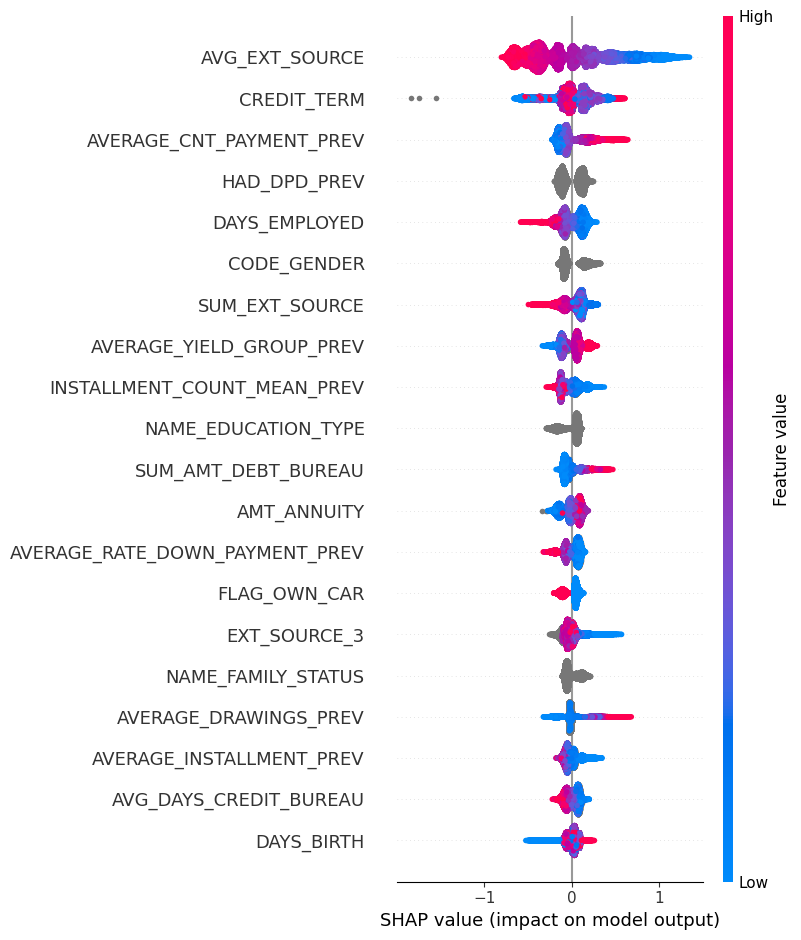

In [32]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_val_cat)
shap.summary_plot(shap_values, X_val_cat)

**Main Insights:**
* **External score** features are the most important predictors of default. In particular, our created feature "AVG_EXT_SOURCE" stands out as the most important. A higher credit score significantly reduces the likelihood of default.
* The newly created **"CREDITTERM"** feature ranks second in importance. However, its relationship with default risk is not entirely straightforward. Individuals with the longest credit terms tend to have a default probability around 50%. The highest default risk is seen in those with moderate credit terms, while individuals with the shortest credit terms exhibit both high and low default probabilities.
* **Number of days employed** and **gender** are also strong predictors of default.
* Having debt in the past also increases default rates. There are several features related to debt that are among most important ones
* It is important to highlight the significant role of features from the **previous_applications.csv** table. Many of these features rank among the most important predictors. Key ones include:
    * **Average number of payments** for previous loans: A very high number of payments on past loans significantly increases the likelihood of default.
    * **Average interest rate for previous loans:** Higher interest rates on past loans are associated with higher default chances.
    * **Late payments in the past:** A history of late payments is also a strong indicator of increased default risk.

**Check features with 0 importance**

In [33]:
shap_feature_importance = pd.DataFrame({
    "feature": X_train_cat.columns,
    "importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="importance", ascending=False)
lgb_zero_importance_features = shap_feature_importance.loc[
    shap_feature_importance["importance"] == 0, "feature"].values
print(f"There are {len(lgb_zero_importance_features)} features with 0 importance")

There are 34 features with 0 importance


Around 34 features have 0 importance. Let's drop them, retrain and check the model performance.

In [34]:
X_train_cat_cleaned = X_train_cat.drop(columns=list(lgb_zero_importance_features))
X_val_cat_cleaned = X_val_cat.drop(columns=list(lgb_zero_importance_features))

X_train_lgbm_dataset = lgb.Dataset(X_train_cat_cleaned,
                               label=y_train)
X_val_lgbm_dataset = lgb.Dataset(X_val_cat_cleaned,
                           label=y_val,
                           reference=X_train_lgbm_dataset)
lgb_model = lgb.train(
    final_lgbm_params,
    X_train_lgbm_dataset,
    valid_sets=[X_train_lgbm_dataset, X_val_lgbm_dataset],
    valid_names=['train', 'val'],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1245]	train's auc: 0.807616	val's auc: 0.784814


The performance of the model is even slightly better. Therefore, we will go with this model, trained on 34 less features.

**Feature importance for Logistic Regression**

In [35]:
log_reg = LogisticRegression(random_state=0, max_iter=700)
log_reg.fit(X_train_under, y_train_under);

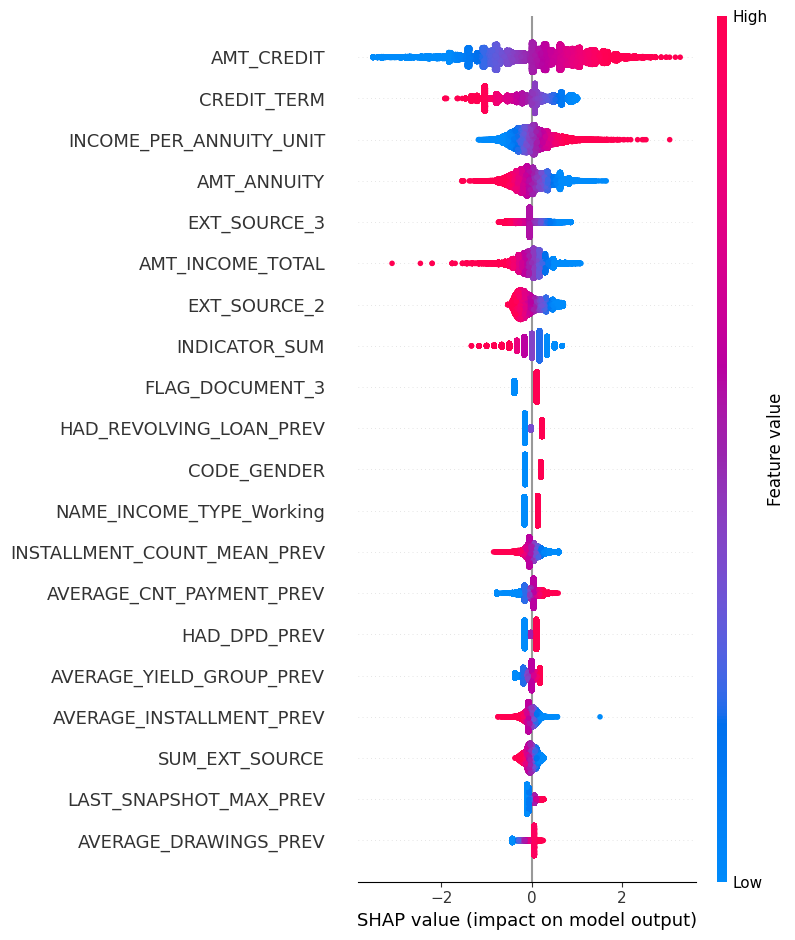

In [36]:
explainer = shap.LinearExplainer(log_reg, X_train_under)
shap_values = explainer(X_val_preprocessed)
feature_names = preprocessing.get_feature_names_out()
feature_names = [name[name.find("__")+2:] for name in feature_names]
shap.summary_plot(shap_values, X_val_preprocessed, feature_names=feature_names)

**Main Insights:**
* The **AMT_CREDIT** feature is the most important predictor in this model. A higher amount of credit is associated with an increased likelihood of default in the Logistic Regression model.
* **CREDITTERM** also holds significant importance in this model. It shows that a longer credit term is associated with lower default chances.
* **External score** features continue to demonstrate high importance in predicting default risk in this model.
* The manually created feature, **INCOME_PER_ANNUITY_UNIT**, ranks among the most important features, highlighting its predictive power.
* It is noteworthy that many features from the **previous_applications.csv** table are also highly ranked. This underscores the value of including historical data from the Home Credit Group when making predictions.

Additionally, the Logistic Regression model assumes linear relationships between the features and the target variable. As a result, the feature importance reflects these linear associations, capturing simpler patterns compared to more complex models.

Check zero importance features:

In [37]:
shap_feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="importance", ascending=False)
log_zero_importance_features = shap_feature_importance.loc[
    shap_feature_importance["importance"] == 0, "feature"].values
print(f"There are {len(log_zero_importance_features)} features with 0 importance")

There are 0 features with 0 importance


Finally, we'll look at the performances of our best models:

In [38]:
best_models = [
    {
        "name": "Logistic Regression", 
        "model": log_reg,
        "X_val": X_val_preprocessed,
        "y_val": y_val
    },
    {
        "name": "Light Gradient Boosting", 
        "model": lgb_model,
        "X_val": X_val_cat_cleaned,
        "y_val": y_val
    }
]

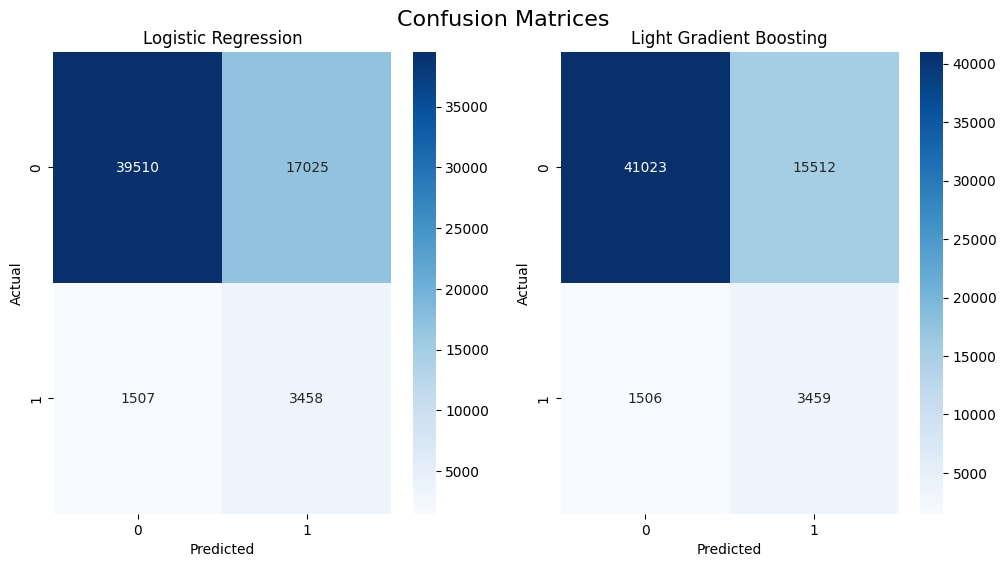

In [39]:
helper_functions.plot_confusion_matrices(best_models, figsize=(12, 6))

By looking at the confusion matrices, we see that logistic regression is almost the same at identifying positive classes as LightGBM, while LightGBM is best at identifying more negative classes and making less False Positives

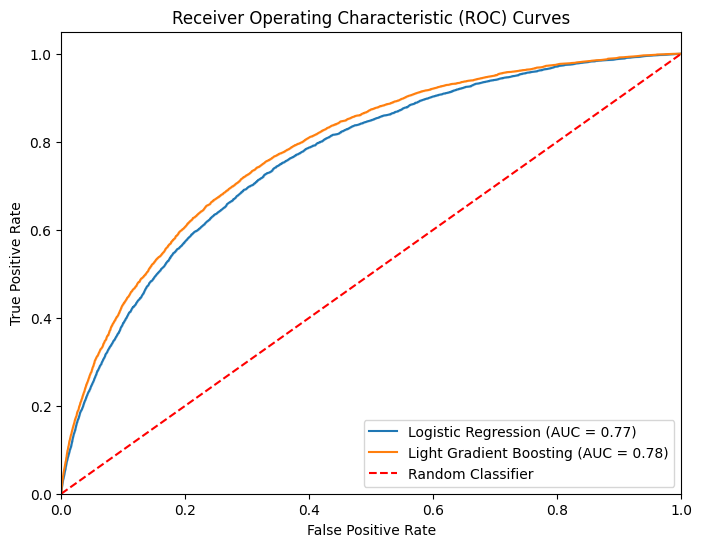

In [41]:
helper_functions.plot_roc_curves(best_models)

Here, we see the ROC curves. Again, LightGBM shows its higher performance.

## Retraining on the full dataset

In [43]:
X_cat = prepare_categorical_datasets(X, 
                                     drop_column=["SK_ID_CURR"] 
                                     + list(lgb_zero_importance_features))
test_cat = prepare_categorical_datasets(test_data, 
                                        drop_column=["SK_ID_CURR"] 
                                        + list(log_zero_importance_features))

X_under, y_under = apply_random_undersampling(X, y)

Starting memory usage of dataframe: 187.68 MB
Final memory usage of dataframe: 71.85 MB
Reduced by: 61.7%
Starting memory usage of dataframe: 42.40 MB
Final memory usage of dataframe: 12.98 MB
Reduced by: 69.4%


In [44]:
X_train_lgbm_dataset = lgb.Dataset(X_cat,
                                   label=y)
lgb_model = lgb.train(
    final_lgbm_params,
    X_train_lgbm_dataset,
    num_boost_round=lgb_model.best_iteration)

log_reg = LogisticRegression(random_state=0, max_iter=700)
log_pipe = Pipeline([
    ("preprocessor", preprocessing),
    ("model", log_reg)
])
log_pipe.fit(X_under, y_under);

**Save models for future deployment**

In [45]:
joblib.dump(log_pipe, '../deployment/log_reg_pipeline.pkl')
joblib.dump(lgb_model, '../deployment/lgbm_model.pkl')

['../deployment/lgbm_model.pkl']

## Conclusions from the Modelling Process:
1. **Baseline Model:**
* The Logistic Regression model was trained using the original features from the applications.csv table. It achieved an ROC AUC of approximately 0.75 on the validation data. The class_weight parameter was used to address the class imbalance.
2. **Imbalance Handling:**
* Three techniques were explored to tackle the class imbalance: adjusting the model's hyperparameters (which control class weights), undersampling the majority class, and using SMOTE. The performance was quite similar across simpler models (Random Forest, Logistic Regression, Decision Tree). Interestingly, in some cases, undersampling resulted in slightly higher scores despite using less data. For gradient boosting models, adjusting the balancing parameters yielded better results.
3. **Model Performance:**
* Among the simpler models (Random Forest, Logistic Regression, and Decision Tree), Logistic Regression emerged as the best performer. It also demonstrated the advantage of producing high scores when trained on undersampled data.
* We also tested gradient boosting models, and LightGBM was selected as the top performer due to its high accuracy and efficient training time.
4. **Final Model Selection:**
* The final models chosen are **LightGBM** and **Logistic Regression**. LightGBM achieved an ROC AUC of 0.785, while Logistic Regression scored 0.766. Despite the slightly lower score, Logistic Regression was chosen for its simplicity and its effective performance on the undersampled dataset.
5. **Feature Importance:**
* Both models identified important features, though there were some differences in the rankings. However, several features appeared in both models' top lists, including:
    * External score features: These proved to have a strong influence on the likelihood of default. A higher external score significantly reduces the chances of default.
    * CreditTerm: This feature was highly important, with longer credit terms associated with a lower probability of default.
    * Features from previous_applications.csv: These also showed high importance, underscoring the value of historical data from the Home Credit Group.
    * Debt-related features: A history of debt significantly increases the likelihood of default.
    * Late payments: Past late payments also contributed to higher default rates.

## Suggestions on improving the project:
* **Feature engineering**: more work could be done on engineering more features. We could create some features from our original table, as well as, adding some from historical data
* **Imputation of missing data**: Only mean imputation was used here in this project. A lot of highly important feature include substantial amount of missing data. By trying to come up with more sophisticated imputation techniques, we could improve our models
* **Addressing Class Imbalance:** While we used techniques such as class weights, undersampling, and SMOTE, other advanced methods could be considered. For example, using ensemble methods like Balanced Random Forest or EasyEnsemble may improve performance in dealing with class imbalance. 
* **Deep learning model**: Given the complexity of the dataset, we could try to train a deep neural-network model and analyze its results.